# Covid Experiment
# WILO: I'm running into fitting erros when cpml leads to observed_p = 1. Surprising so something is wrong.

See WILO and Covid Experiment Blog Post Bear Note.

Assuming steady state.


https://gist.github.com/csaid/84819e16bae145b0139b57521f852a11

At steady state, the concentration in a room is Ef/VR where E is the rate of exhaled virus, f is filtration, V is the volume of the room, and R is the virus removal rate (i.e. the sum of ventilation rate, viral decay, aerosol deposition)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import pymc3 as pm
import arviz as az
from scipy.stats import t
from scipy.optimize import minimize
from bisect import bisect
import logging
import warnings


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
logger = logging.getLogger("pymc")
logger.setLevel(logging.WARNING)


In [4]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
blue='#3ac3f2'
pink='#ed2685'
gray='#aaaaaa'
lightgray='#cccccc'
yellow='#f1d321'
orange='#f58032'
green='#12ed9d'
red='#ed1262'

In [6]:
def get_hazard_rate(cpml, base_multiplier=1e-7, multiplier=1):

    # See note above for where this formula comes from
    return base_multiplier * multiplier * cpml

def get_flattened_cpml(cpml, secondary_volunteer_counts):
    flattened_cpml = []
    for index_cpml, cnt in zip(cpml, secondary_volunteer_counts):
        for i in range(cnt):
            flattened_cpml.append(index_cpml)
    return flattened_cpml

def fit_curve(flattened_cpml, did_infects, fit_susceptibilities=False):
    """
    flattened_cpml is a list of viral counts of the index cases, but flattened out to the total number of secondary_cases. 
    It is of length num_index_cases * num_secondary_cases_per_index

    did_infects is a list of 1s and 0s of the same length. It records whether an viral transmission 
    occurred between the index case and the secondary case.
    """

    n = len(flattened_cpml)

    
    with pm.Model() as model:
        # Beta defines how much viral load (flattened_cpml) causes an increase in the hazard rate lmbd
        log_beta = pm.Normal('log_beta', mu=-6, sigma=5)        
        beta = pm.math.exp(log_beta * pm.math.log(10)) # Like beta = 10**log_beta, but staying within the computational graph

        if fit_susceptibilities:
            # Every secondary case has a certain susceptibility. 
            suscept_sd = pm.HalfNormal('suscept_sd', sd=0.5)
            log_suscept = pm.Normal('log_suscept', mu=0, sigma=suscept_sd, shape=n)
            suscept = pm.math.exp(log_suscept * pm.math.log(10))
            
            # Hazard rate lmbd is linear function of viral count (flattened_cpml)
            lmbd = beta * flattened_cpml * suscept
            

        else:
            # Hazard rate is linear function of viral count
            lmbd = beta * flattened_cpml


        # Infection probability
        p = 1 - pm.math.exp(-lmbd)
        
        # Likelihood
        y_obs = pm.Bernoulli('y_obs', p=p, observed=did_infects)
        
        # MCMC sampling
        trace = pm.sample(1000, tune=1000, target_accept=0.95, chains=2, progressbar=False)

    return trace

In [7]:
def infects_to_counts(infections, secondary_volunteer_counts):
    did_infects_idx = 0
    infection_counts = []
    for group_idx, group_len in enumerate(secondary_volunteer_counts):
        infection_count = 0
        for i in range(group_len):
            infection_count += infections[did_infects_idx]
            
            did_infects_idx += 1
        infection_counts.append(infection_count)
    return infection_counts
    
def simulate_experiment(flattened_cpml, secondary_volunteer_counts, suscept_sd=1, multiplier=1):
    n = len(flattened_cpml)
    infections = []
    susceptibilities = 10**(suscept_sd * np.random.randn(n))


    lmbd = get_hazard_rate(flattened_cpml * susceptibilities, multiplier=multiplier)
    p = 1 - np.exp(-lmbd)
    infections = np.random.rand(n) < p
    infections = np.array([float(b) for b in infections])
    infection_counts = infects_to_counts(infections, secondary_volunteer_counts)
    return infection_counts, infections
    

In [ ]:
def get_samples(trace, viral_count_range, include_susceptibilities=False):

    log_beta_samples = trace["log_beta"]
    beta_samples = 10**log_beta_samples

    if include_susceptibilities:
        suscept_sd_samples = trace["suscept_sd"]
        suscept_samples = [10**(sd * np.random.randn()) for sd in suscept_sd_samples]
        lmbd_samples = np.outer(beta_samples * suscept_samples, viral_count_range)
    else:
        lmbd_samples = np.outer(beta_samples, viral_count_range)
    
    p_samples = 1 - np.exp(-lmbd_samples)
    return lmbd_samples, p_samples


def get_credible_interval(samples):
    # Compute mean and percentiles of p
    mean = np.mean(samples, axis=0)
    lower = np.percentile(samples, 2.5, axis=0)
    upper = np.percentile(samples, 97.5, axis=0)
    return mean, lower, upper

def plot_credible_prob_curve(viral_count_range, cpml, infection_rates, p_mean, p_lower, p_upper, include_labels=True, fill_label="95% CI", color=blue):
    label = "Mean Infection Probability" if include_labels else '_nolegend_'
    plt.plot(viral_count_range, p_mean, color=gray, label=label)
    plt.fill_between(viral_count_range, p_lower, p_upper, color=color, alpha=0.3, label=fill_label)
    label = "Observed Data" if include_labels else '_nolegend_'
    plt.scatter(cpml, infection_rates, s=10, zorder=5, color=color, label=label)
    plt.xscale("log")

def format_curve_plot():
    plt.xlabel("Viral Count (cp/mL)")
    plt.ylabel("Infection Probability")
    plt.legend()

def run(flattened_cpml, infections, fit_susceptibilities):
    trace = fit_curve(flattened_cpml, infections, fit_susceptibilities=fit_susceptibilities)
    print(az.summary(trace, round_to=2))
    idata = az.from_pymc3(trace)
    az.plot_trace(idata)
    plt.tight_layout()

    plt.figure()
    viral_count_range = 10**np.linspace(0, 10, 5000)
    lmbd_samples, p_samples = get_samples(trace, viral_count_range, include_susceptibilities=False)
    p_mean, p_lower, p_upper = get_credible_interval(p_samples)
    plot_credible_prob_curve(viral_count_range, cpml, infection_rates, p_mean, p_lower, p_upper)
    format_curve_plot()

    return trace

# Ventilation Power Analysis
WILO: Jan 7, 2023. 

Can show that n=200 is a lot better than n=100. Higher susceptibility variance actually *improves* power. By flattening the curve it makes fitting easier. MCMC fits are a subsequent nice-to-have followup that don't need a power analysis (which is infeasible anyway).

Also think about ways to use repeated measure where the same index case goes into a ventilated room for an hour and an unventilated room for an hour. Although maybe I'm capturing most of that value anyway by modeling cpml. 



In [10]:
def random_swap_arrays(arr1, arr2):

    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must be of the same size.")

    # Randomly choose which array to pick the first element from for each position
    choices = np.random.choice([0, 1], size=len(arr1))

    # Create output arrays
    output1 = np.where(choices == 0, arr1, arr2)
    output2 = np.where(choices == 0, arr2, arr1)

    return output1, output2


# Logistic function with L fixed at 1.0
def logistic(x, k, x0):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Combined error function for both datasets
def combined_error(params, x1, y1, x2, y2):
    k, x01, x02 = params
    error1 = np.sum((logistic(x1, k, x01) - y1) ** 2)
    error2 = np.sum((logistic(x2, k, x02) - y2) ** 2)
    return error1 + error2


def joint_logistic_fit(log_cpml, infection_counts_lo, infection_counts_hi):
    initial_guess = [2, 5, 5]
    result = minimize(combined_error, initial_guess, args=(log_cpml, infection_counts_lo, log_cpml, infection_counts_hi))
    
    # Optimized parameters
    k_opt, x01_opt, x02_opt = result.x
    k_opt, x01_opt, x02_opt
    
    return {
        'k_opt': k_opt,
        'x01_opt': x01_opt, 
        'x02_opt': x02_opt,
        'diff': x02_opt - x01_opt
    }

In [11]:
def get_logistic_signficance(actual_diff, log_cpml, infection_rates_lo, infection_rates_hi):
    null_diffs = []
    for iter in range(250):
        permuted_infection_rates_lo, permuted_infection_rates_hi = random_swap_arrays(infection_rates_lo, infection_rates_hi)
        permuted_logistic_params = joint_logistic_fit(log_cpml, permuted_infection_rates_lo, permuted_infection_rates_hi)
        null_diffs.append(permuted_logistic_params['diff'])
    null_diffs = sorted(null_diffs)
    p = bisect(null_diffs, actual_diff) / len(null_diffs)
    return p < 0.05
    

In [12]:
def run_simulation(num_index_cases=20,
                   num_secondaries_per_index=10,
                   suscept_sd=0.5,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=30):

    significance_list = []
    for iter in range(niter):
    

        secondary_volunteer_counts = np.array([num_secondaries_per_index] * num_index_cases)
        multiplier = 1
        cpml = 11**np.sort(6*np.random.rand(num_index_cases) + 2.5)
        log_cpml = np.log10(cpml)
        flattened_cpml = get_flattened_cpml(cpml, secondary_volunteer_counts)
        
        infection_counts_lo, infections_lo = simulate_experiment(flattened_cpml, secondary_volunteer_counts, suscept_sd=suscept_sd, multiplier=multiplier_lo)
        infection_counts_hi, infections_hi = simulate_experiment(flattened_cpml, secondary_volunteer_counts, suscept_sd=suscept_sd, multiplier=multiplier_hi)
        infection_rates_lo = infection_counts_lo / secondary_volunteer_counts
        infection_rates_hi = infection_counts_hi / secondary_volunteer_counts
        
        
        logistic_params = joint_logistic_fit(log_cpml, infection_rates_lo, infection_rates_hi)
        
        
        is_significant = get_logistic_signficance(logistic_params['diff'], log_cpml, infection_rates_lo, infection_rates_hi)
        significance_list.append(is_significant)
    last_iter_logistic_params = logistic_params
    print('Power:', np.array(significance_list).mean())
    return log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params

In [13]:
def plot_logistic(log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params):
    log_viral_count_range = np.linspace(0, 10, 5000)
    plt.scatter(log_cpml, infection_rates_lo, label='High ventilation', color=pink)
    plt.scatter(log_cpml, infection_rates_hi, label='Low ventilation', color=blue)
    plt.plot(log_viral_count_range, logistic(log_viral_count_range, last_iter_logistic_params['k_opt'], last_iter_logistic_params['x01_opt']), color=pink)
    plt.plot(log_viral_count_range, logistic(log_viral_count_range, last_iter_logistic_params['k_opt'], last_iter_logistic_params['x02_opt']), color=blue)
    xticks = plt.xticks()
    plt.xticks(xticks[0], [f'$10^{int(x)}$' for x in xticks[0]])
    plt.xlabel('Viral count (cp/mL)')
    plt.ylabel('Transmission rate')
    plt.legend()
    plt.show()

Power: 0.755


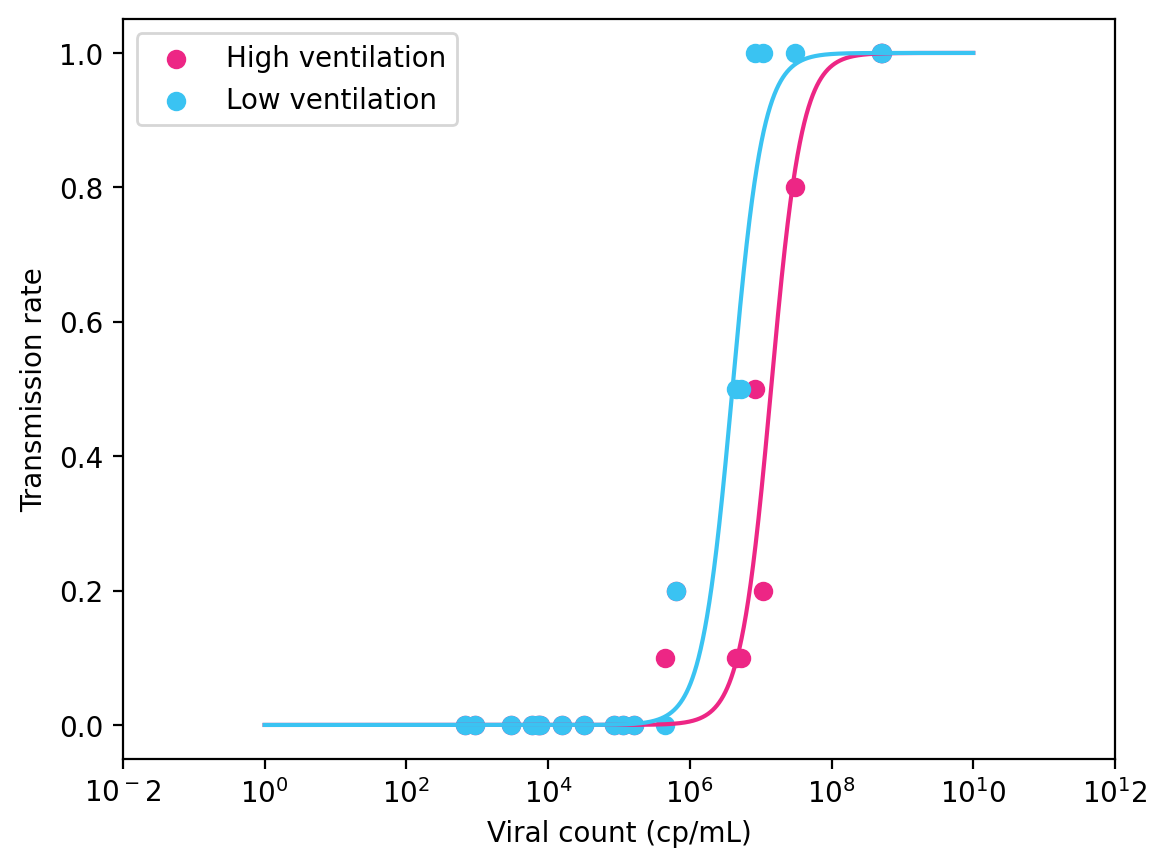

In [14]:
log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params = run_simulation(
                   num_index_cases=20,
                   num_secondaries_per_index=10,
                   suscept_sd=0.0,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=200)
plot_logistic(log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params)

Power: 0.76


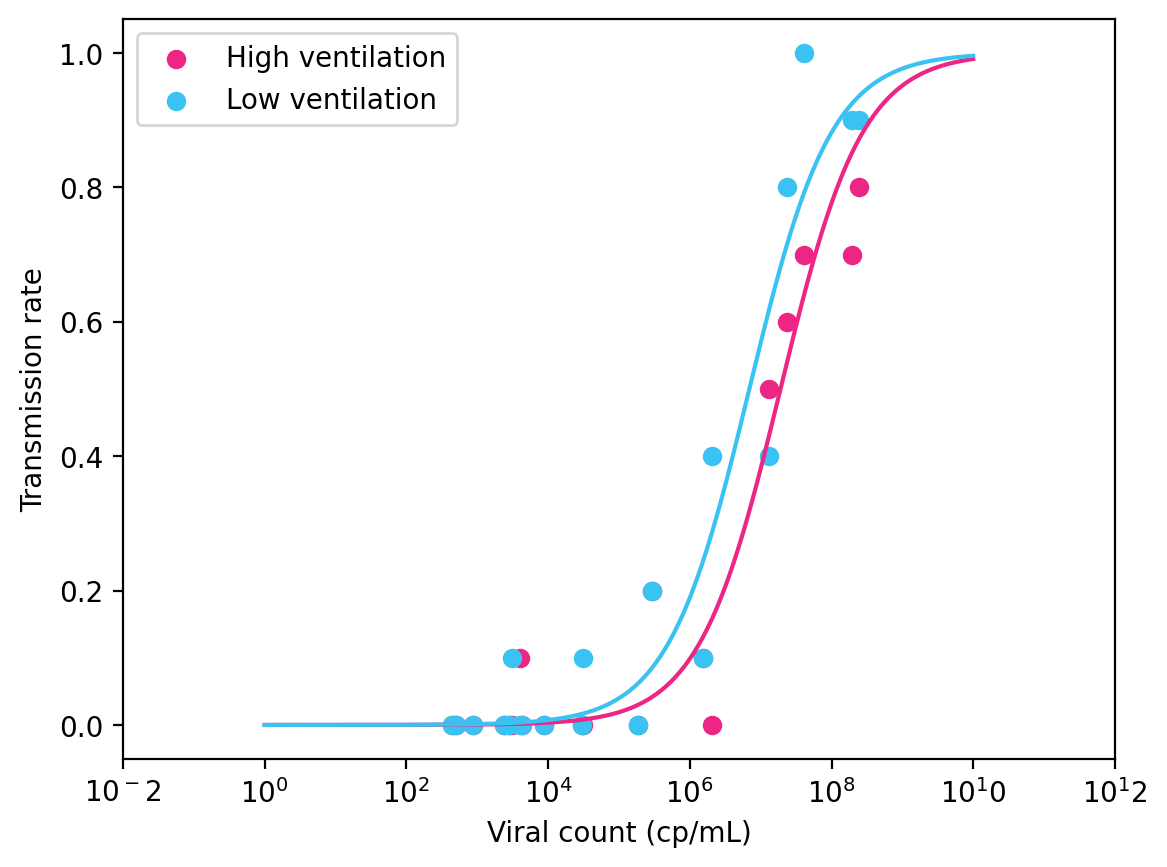

In [15]:
log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params = run_simulation(
                   num_index_cases=20,
                   num_secondaries_per_index=10,
                   suscept_sd=1.0,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=200)
plot_logistic(log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params)

Power: 0.235


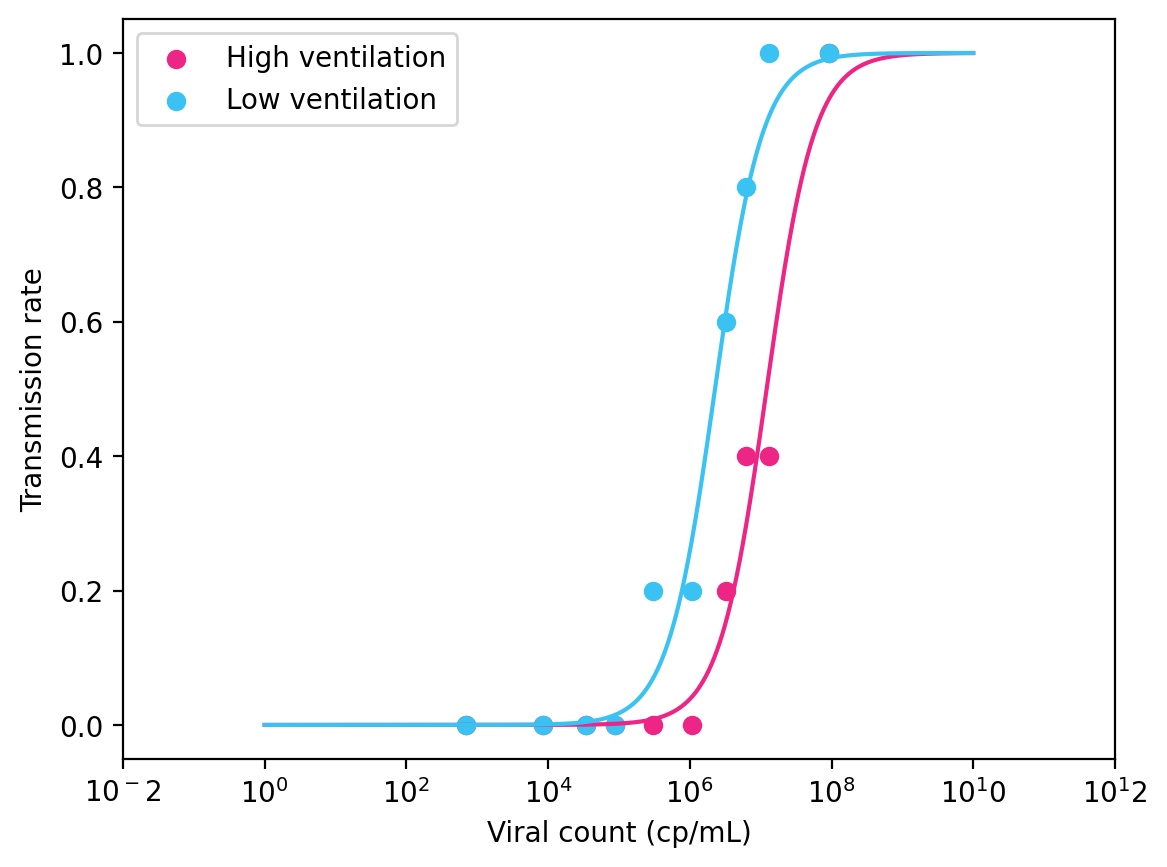

In [16]:
log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params = run_simulation(
                   num_index_cases=10,
                   num_secondaries_per_index=10,
                   suscept_sd=0.0,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=200)
plot_logistic(log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params)

Power: 0.405


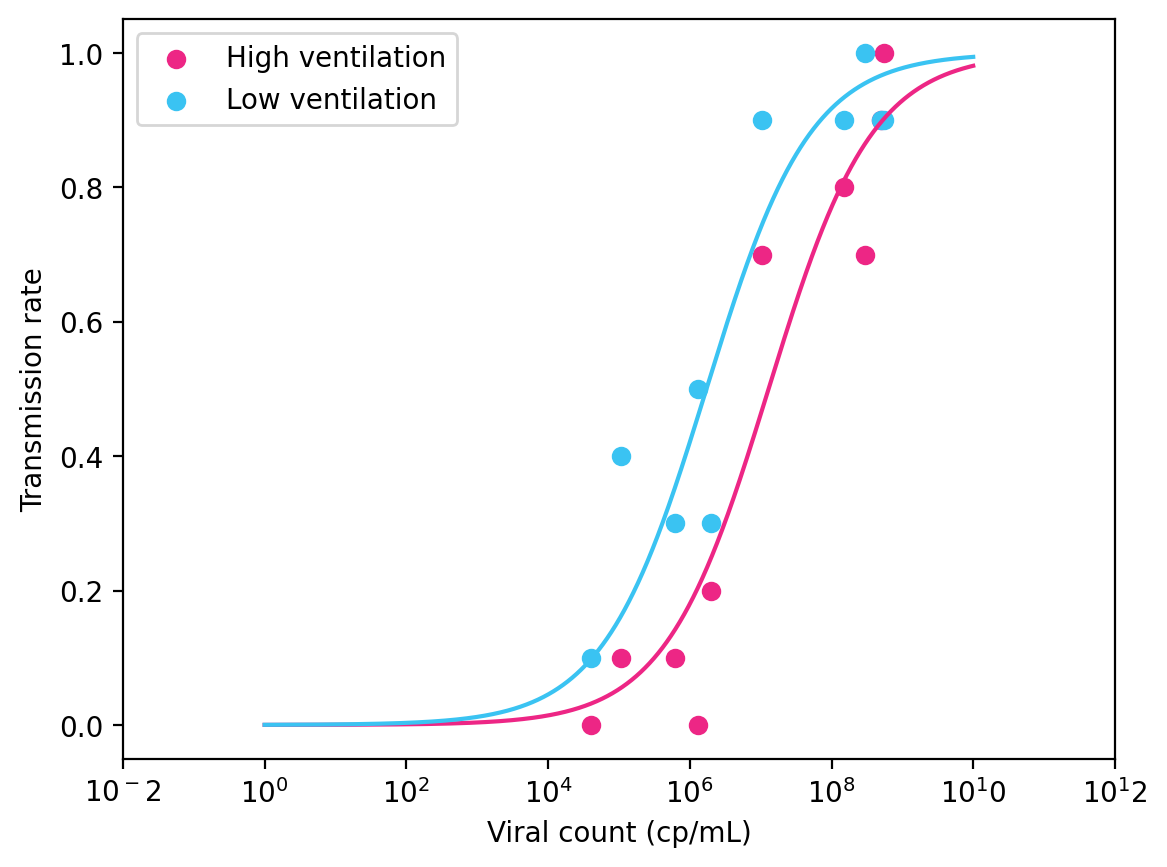

In [17]:
log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params = run_simulation(
                   num_index_cases=10,
                   num_secondaries_per_index=10,
                   suscept_sd=1.0,
                   multiplier_lo=0.5,
                   multiplier_hi=2,
                   niter=200)
plot_logistic(log_cpml, infection_rates_lo, infection_rates_hi, last_iter_logistic_params)

### Ventilation MCMC (fitting susceptibilities)

In [21]:
num_index_cases = 10
num_secondaries_per_index = 10
suscept_sd = 1

In [22]:
secondary_volunteer_counts = np.array([num_secondaries_per_index] * num_index_cases)
cpml = 11**np.sort(6*np.random.rand(num_index_cases) + 2.5)
log_cpml = np.log10(cpml)
flattened_cpml = get_flattened_cpml(cpml, secondary_volunteer_counts)

infection_counts_lo, infections_lo = simulate_experiment(flattened_cpml, secondary_volunteer_counts, suscept_sd=suscept_sd, multiplier=1/2)
infection_counts_hi, infections_hi = simulate_experiment(flattened_cpml, secondary_volunteer_counts, suscept_sd=suscept_sd, multiplier=2)


In [23]:
trace_lo = fit_curve(flattened_cpml, infections_lo, fit_susceptibilities=True)
print(az.summary(trace_lo, round_to=2))

trace_hi = fit_curve(flattened_cpml, infections_hi, fit_susceptibilities=True)
print(az.summary(trace_hi, round_to=2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_suscept, suscept_sd, log_beta]
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


                 mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
log_beta        -7.44  0.20   -7.80    -7.07       0.01     0.01    585.96  \
log_suscept[0]  -0.01  0.72   -1.39     1.44       0.02     0.03   2269.15   
log_suscept[1]  -0.02  0.73   -1.51     1.33       0.01     0.03   3867.98   
log_suscept[2]  -0.02  0.75   -1.41     1.48       0.02     0.03   2351.31   
log_suscept[3]   0.00  0.72   -1.35     1.38       0.01     0.02   2871.35   
...               ...   ...     ...      ...        ...      ...       ...   
log_suscept[96]  0.12  0.64   -1.05     1.32       0.02     0.02   1870.90   
log_suscept[97]  0.12  0.66   -1.10     1.38       0.01     0.02   3067.88   
log_suscept[98]  0.10  0.61   -1.03     1.25       0.01     0.02   2093.33   
log_suscept[99]  0.09  0.65   -1.18     1.25       0.01     0.02   2678.79   
suscept_sd       0.69  0.24    0.16     1.05       0.03     0.02     59.10   

                 ess_tail  r_hat  
log_beta          1255.86   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_suscept, suscept_sd, log_beta]
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


                 mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
log_beta        -6.52  0.23   -6.94    -6.09       0.01     0.00   1138.52  \
log_suscept[0]  -0.01  0.99   -1.84     1.87       0.02     0.03   3700.64   
log_suscept[1]  -0.02  0.92   -1.93     1.63       0.02     0.02   2947.44   
log_suscept[2]  -0.00  0.97   -1.85     1.87       0.01     0.03   4204.67   
log_suscept[3]  -0.01  0.95   -1.89     1.69       0.02     0.03   2695.35   
...               ...   ...     ...      ...        ...      ...       ...   
log_suscept[96]  0.05  0.90   -1.52     1.86       0.02     0.02   3522.21   
log_suscept[97]  0.05  0.88   -1.67     1.58       0.02     0.02   2566.40   
log_suscept[98]  0.06  0.94   -1.72     1.80       0.01     0.03   3965.61   
log_suscept[99]  0.04  0.86   -1.63     1.60       0.01     0.02   3794.76   
suscept_sd       0.93  0.19    0.58     1.28       0.02     0.01    106.88   

                 ess_tail  r_hat  
log_beta          1053.25   

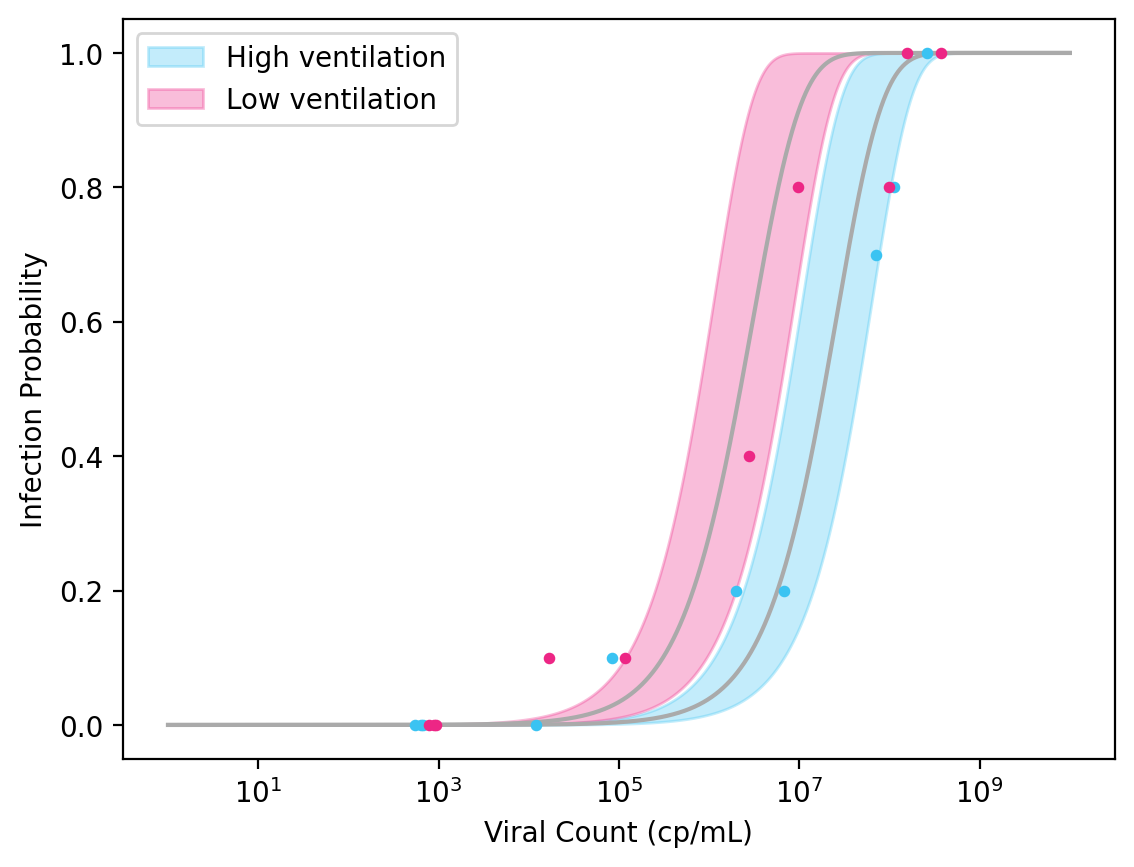

In [24]:
for shift, color, fill_label, trace, infection_count in zip(
                                                     [1, 1.4],
                                                     [blue, pink],
                                                     ['High ventilation', 'Low ventilation'],
                                                     [trace_lo, trace_hi],
                                                     [infection_counts_lo, infection_counts_hi]):
    viral_count_range = 10**np.linspace(0, 10, 5000)
    lmbd_samples, p_samples = get_samples(trace, viral_count_range, include_susceptibilities=False)
    p_mean, p_lower, p_upper = get_credible_interval(p_samples)
    infection_rates = infection_count/secondary_volunteer_counts
    plot_credible_prob_curve(viral_count_range, shift*cpml, infection_rates, p_mean, p_lower, p_upper, color=color, include_labels=False, fill_label=fill_label)
format_curve_plot()

(array([  6.,  30., 171., 433., 568., 469., 239.,  63.,  17.,   4.]),
 array([-7.32756585, -7.15431261, -6.98105937, -6.80780613, -6.63455289,
        -6.46129965, -6.28804641, -6.11479317, -5.94153993, -5.76828669,
        -5.59503345]),
 <BarContainer object of 10 artists>)

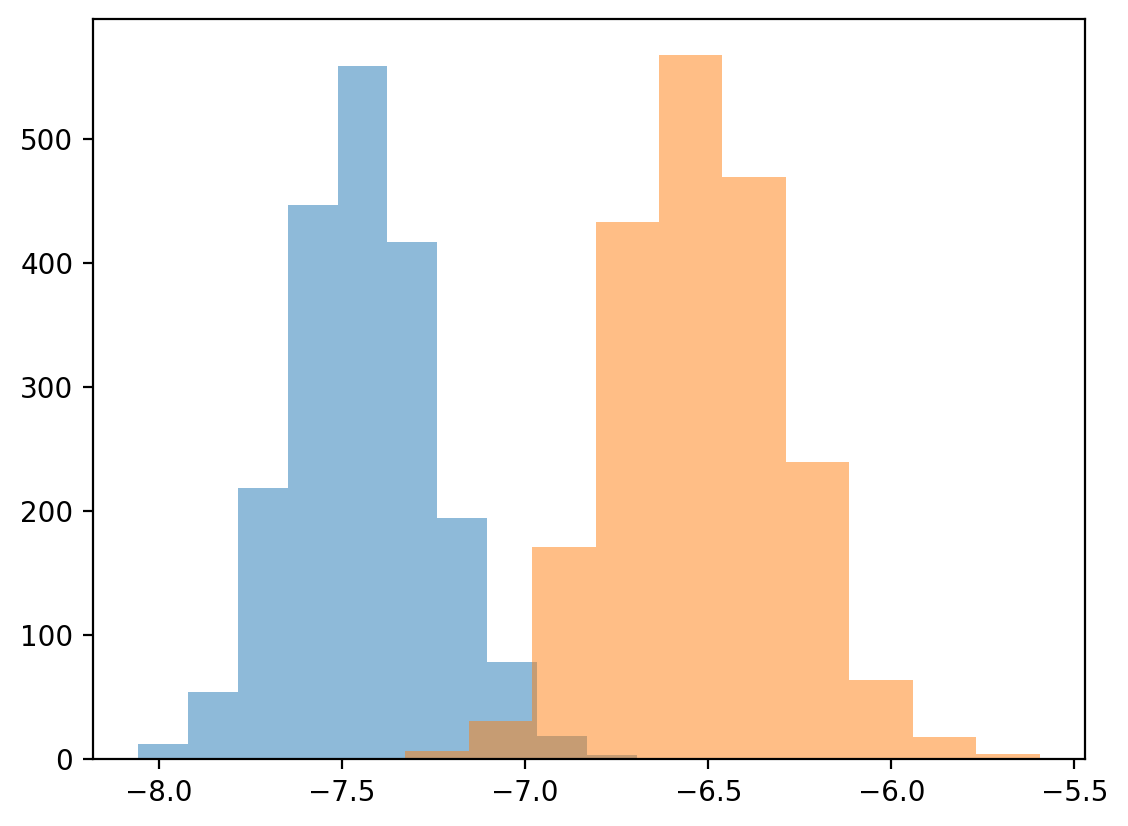

In [25]:
plt.hist(trace_lo['log_beta'], alpha=0.5)
plt.hist(trace_hi['log_beta'], alpha=0.5)

# Comparing fits with and without fitting susceptibilities

In [27]:
num_index_cases = 20
num_secondaries_per_index = 20
multiplier = 1
secondary_volunteer_counts = np.array([num_secondaries_per_index] * num_index_cases)
cpml = 10**np.sort(8*np.random.rand(num_index_cases) + 2.5)
flattened_cpml = get_flattened_cpml(cpml, secondary_volunteer_counts)

suscept_sd = 1.0
infection_counts, infections = simulate_experiment(flattened_cpml, secondary_volunteer_counts, suscept_sd=suscept_sd, multiplier=multiplier)
infection_rates = infection_counts/secondary_volunteer_counts

### Not fitting susceptibilities

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_beta]
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
log_beta  -7.7  0.06   -7.82    -7.59        0.0      0.0    618.45    612.21  \

          r_hat  
log_beta    1.0  


<MultiTrace: 2 chains, 1000 iterations, 1 variables>

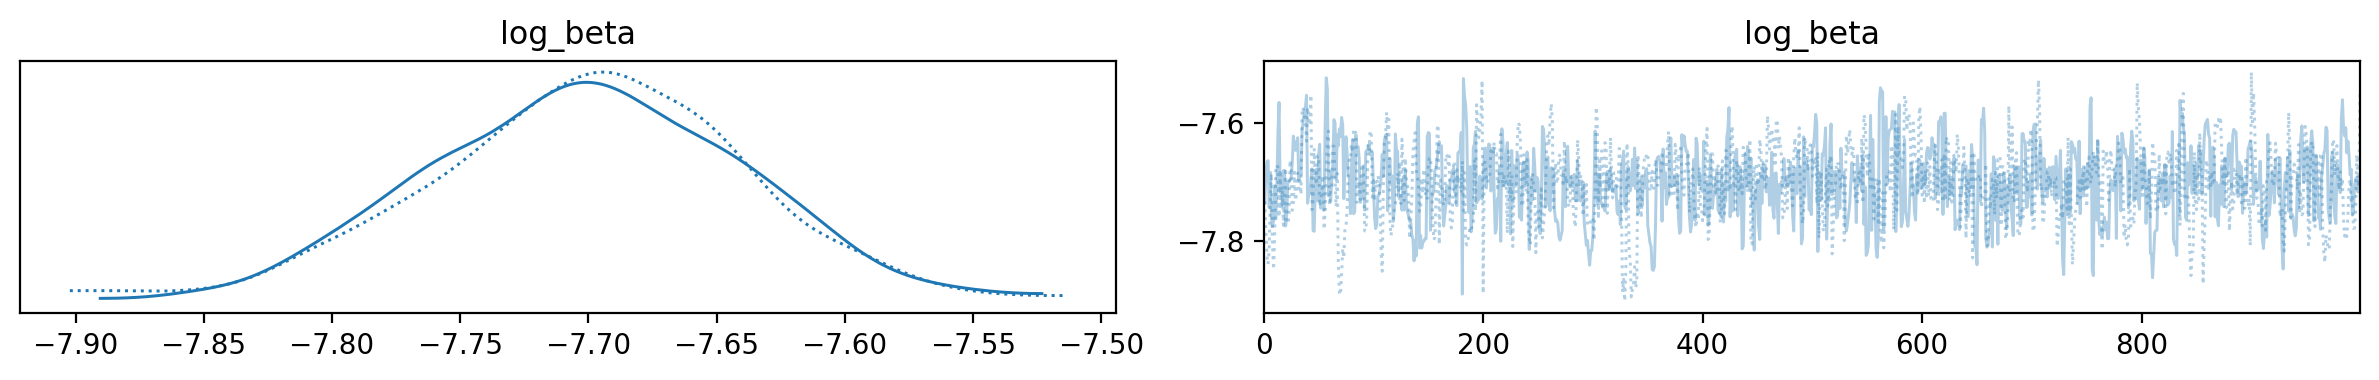

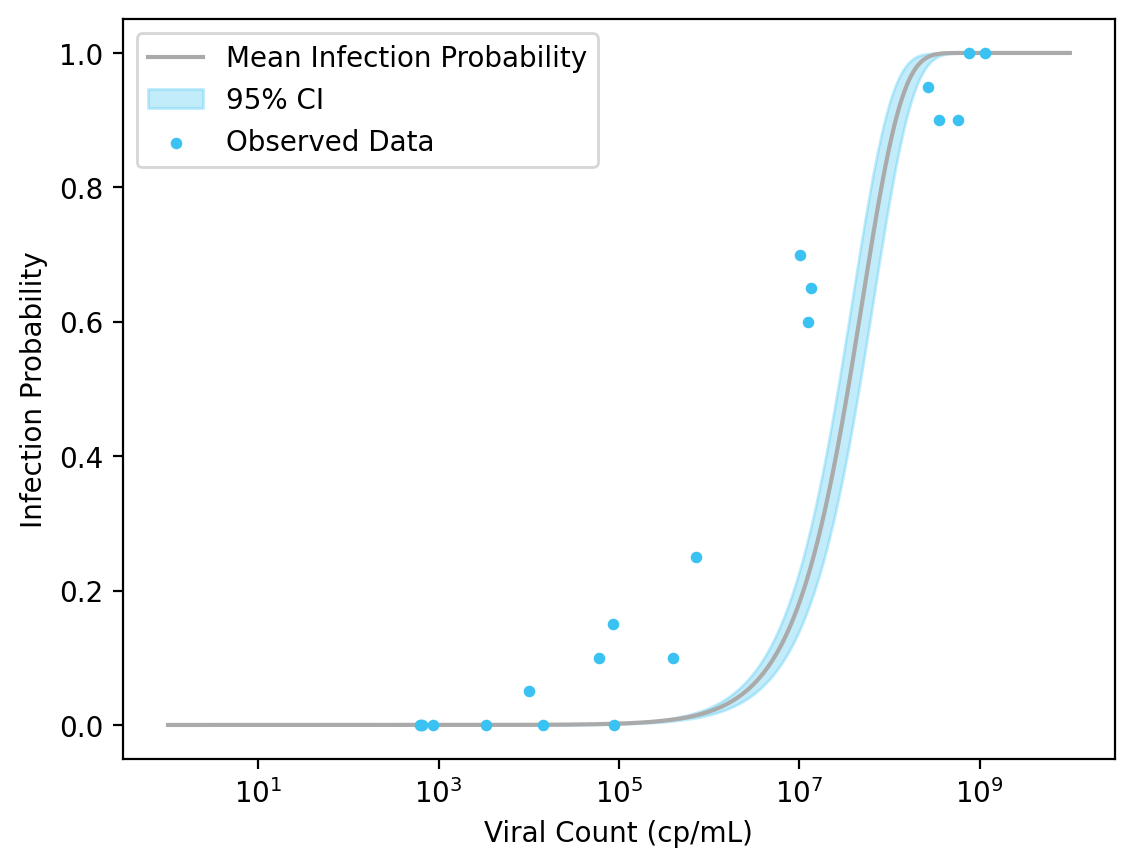

In [28]:
run(flattened_cpml, infections, fit_susceptibilities=False)

### Fitting susceptibilities
The CIs show the distribution of p_infect aggregated over susceptibilities

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_suscept, suscept_sd, log_beta]
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/chrissaid/miniconda3/envs/personal/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


                  mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk   
log_beta         -6.93  0.12   -7.15    -6.73       0.00     0.00   1714.11  \
log_suscept[0]   -0.01  1.09   -2.08     1.94       0.02     0.03   5157.99   
log_suscept[1]   -0.02  1.08   -1.87     2.23       0.02     0.04   4136.62   
log_suscept[2]    0.02  1.07   -1.99     1.91       0.01     0.03   5160.79   
log_suscept[3]   -0.01  1.02   -1.98     1.82       0.02     0.03   4476.75   
...                ...   ...     ...      ...        ...      ...       ...   
log_suscept[396]  0.08  0.99   -1.63     1.88       0.01     0.03   4798.61   
log_suscept[397]  0.06  1.00   -1.89     1.95       0.01     0.02   5909.26   
log_suscept[398]  0.06  1.01   -1.81     1.87       0.01     0.02   5742.26   
log_suscept[399]  0.07  1.02   -1.76     1.98       0.02     0.03   3832.05   
suscept_sd        1.06  0.10    0.86     1.26       0.01     0.00    249.04   

                  ess_tail  r_hat  
log_beta       

<MultiTrace: 2 chains, 1000 iterations, 4 variables>

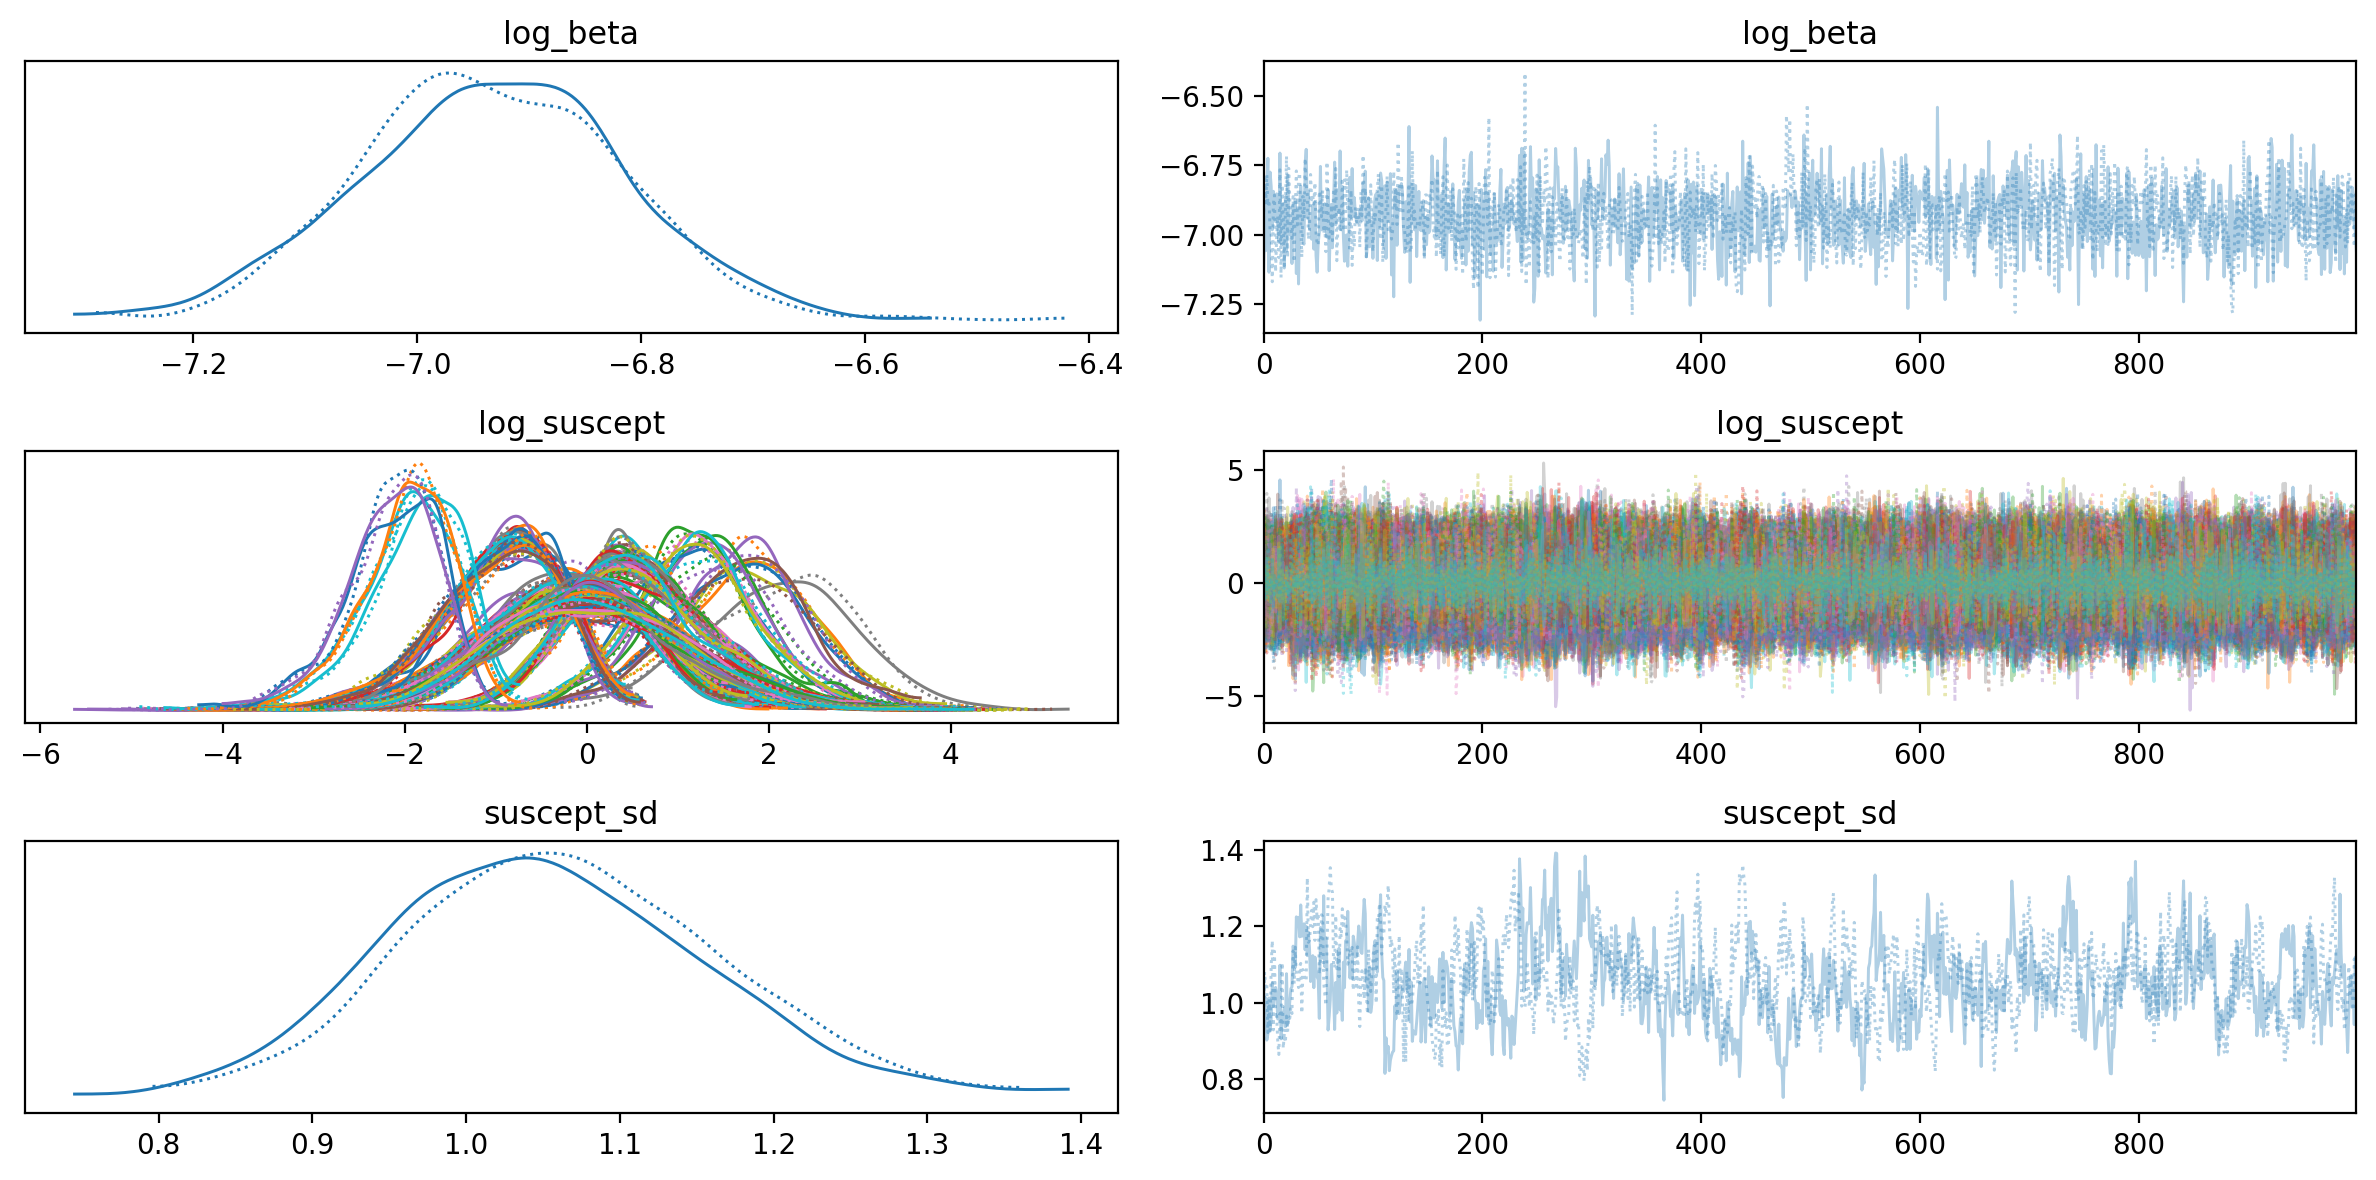

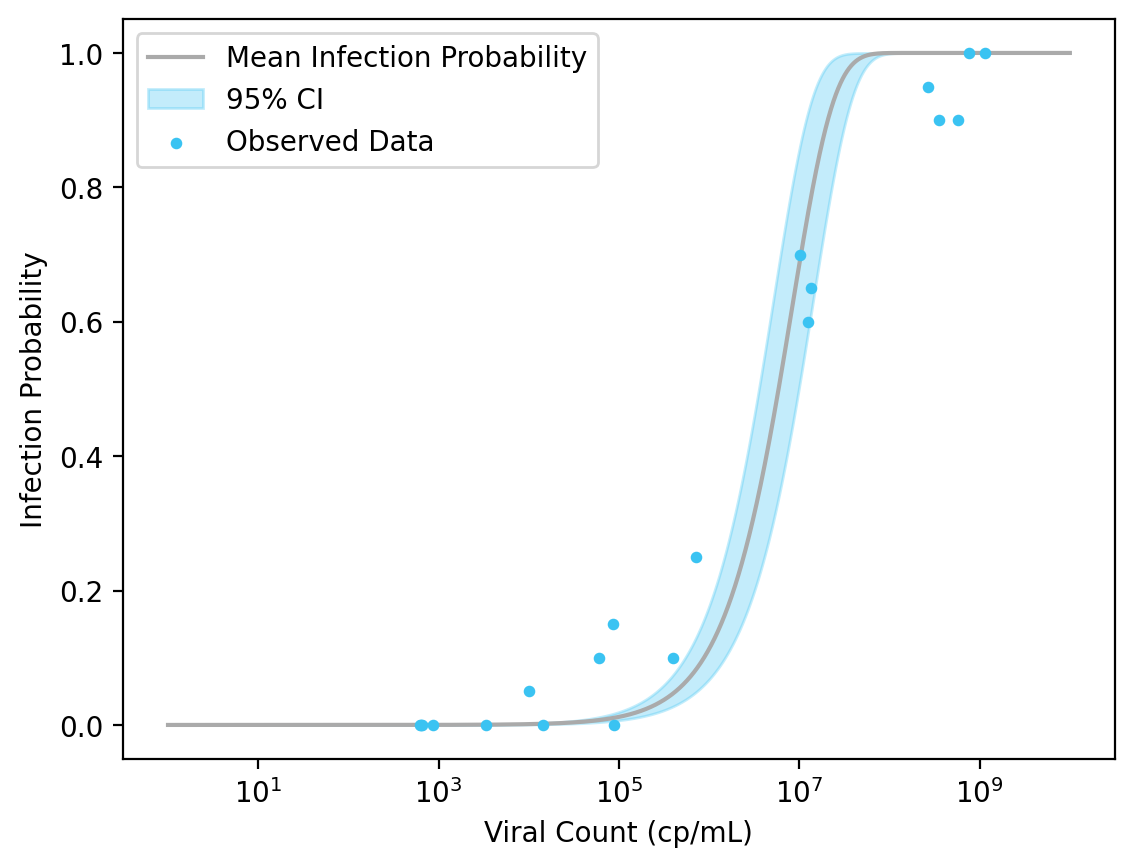

In [29]:
run(flattened_cpml, infections, fit_susceptibilities=True)

# Graveyard
Stuff before I started fitting susceptibilities

In [176]:
# def simulate_experiment(secondary_volunteer_counts, cpml, multiplier=1):
#     lmbd = get_hazard_rate(cpml, multiplier=multiplier) # true function
#     p = 1 - np.exp(-lmbd * t) # true function
    
#     # Observed
#     infection_counts = np.random.binomial(n = secondary_volunteer_counts, p=p)
#     return infection_counts


# def fit_curve(cpml, num_secondaries_per_index, infection_counts):

#     with pm.Model() as model:
#         # Priors for alpha and beta
#         log_beta = pm.Normal('log_beta', mu=-6, sigma=5)
    
#         # Like beta = 10**log_beta, but staying within the computational graph
#         beta = pm.math.exp(log_beta * pm.math.log(10))
        
#         # Hazard rate is linear function of viral count
#         lmbd = beta * cpml
        
#         # Infection probability
#         p = 1 - pm.math.exp(-lmbd)
        
#         # Likelihood
#         y_obs = pm.Binomial('y_obs', n=num_secondaries_per_index, p=p, observed=infection_counts)
        
#         # MCMC sampling
#         trace = pm.sample(2000, tune=1000, target_accept=0.95, chains=2)

#     return trace